In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import seaborn as sns
import os

In [2]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 22
SMALL_SMALL_SIZE = 13

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
FIG_PREFIX = 'revision2/webpage'

In [35]:
ALL_METHODS = ['BEST', 'FREE', 'LPMS', 'Trigram',]

In [5]:
root_dir = '../result/webpages_result'
root_free_dir = '../result/webpages_free_result'
root_lpms_dir = '../result/webpages_lpms_result'
trigram_dir = '../result/trigram_result/result/webpages_trigram_result'
id_cols = ['name', 'num_threads', 'gram_size', 'selectivity', 'num_keys']

In [6]:
rev_dir = '../result/revision/webpages'

In [7]:
def build_stats_filename(row, previous_version, reduced):
    name = row['name']
    if 'parallel' in name:
        name = name.split('-')[0]
    if 'VGGraph-Greedy' in name:
        name = 'VGGRAPH'
    fields = [name, str(int(row['num_threads'])), str(int(row['gram_size'])), str(row['selectivity'] if row['selectivity'] > 0 else -1), 'stats.csv']
    if 'Trigram' in name:
        fields[2] = '-1'
    if not previous_version:
        if reduced is not None:
            fields.insert(-1, str(reduced))
        elif 'BEST' in name:
            fields.insert(-1, '-1')
    space_file = f"time_report_"
    if 'LPMS' in name:
        space_file += f"lpms_t{row['num_threads']}"
        space_file += '_determ' if 'DETER' in name else '_random'
        # max_num = -1
    else:
        if 'VGGraph-Greedy' in row['name']:
            space_file += f"{row['name'].lower().replace('-', '_')}_t{int(row['num_threads'])}"
        else:
            space_file += f"{name.lower()}_t{int(row['num_threads'])}"
        if reduced is not None:
            space_file += f"_red{reduced/1000:g}"
        if 'Trigram' not in name:
            space_file += f"_c{row['selectivity']}"
        if 'FREE' in name or 'VG' in name:
            space_file += f"_n{int(row['gram_size'])}"
    if 'key_upper_bound' in row:
            space_file += f"_{int(row['key_upper_bound'])}"
            fields.insert(-1, str(int(row['key_upper_bound'])))
    space_file += '.txt'
    return '_'.join(fields), space_file   

In [8]:
def get_compute_space(space_f, root_dir=root_dir):
    fullname = os.path.join(root_dir, space_f)
    try:
        with open(fullname, 'r') as file:
            for line in file:
                if 'Maximum resident set size (kbytes)' in line:
                    return int(line.strip().split(': ')[-1].strip())
    except:
        # print(f'Error reading file {fullname}')
        pass
    return -1

In [9]:
def get_stats_df(row, previous_version=False, reduced=None, root_dir=root_dir):
    fname, space_f = build_stats_filename(row, previous_version, reduced)
    return pd.read_csv(os.path.join(root_dir, fname), sep='\t'), get_compute_space(space_f, root_dir)

In [10]:
def add_num_after_filter(df, previous_version=False, reduced_list=None, root_dir=root_dir):
    new_cols = {
        'num_after_filter': [],
        'per_query_num_after_filter': [],
        'match_count': [],
        'compute_size': []
    }
    idx = 0
    reduced = None
    if reduced_list is not None:
        assert(reduced_list is None or len(reduced_list) == df.shape[0])
    for _, row in df.iterrows():
        if reduced_list is not None:
            reduced = reduced_list[idx]
            idx += 1
        detail_df, compute_size = get_stats_df(row, previous_version, reduced=reduced, root_dir=root_dir)
        new_cols['num_after_filter'].append(detail_df['num_after_filter'].sum())
        new_cols['per_query_num_after_filter'].append(detail_df['num_after_filter'].mean())
        new_cols['match_count'].append(detail_df['count'].sum())
        new_cols['compute_size'].append(compute_size)
    return df.assign(**new_cols)

In [11]:
def build_result_df(root_dir, previous_version=False, reduced=None):
    summary_path = os.path.join(root_dir, 'summary.csv')
    summary_df = pd.read_csv(summary_path)
    summary_df.ffill(inplace=True)
    summary_df['overall_match_time'] = summary_df['compile_time'] + summary_df['match_time']
    summary_df.rename(columns={'overall_time': 'overall_index_time', '    name': 'name'}, inplace=True)
    summary_df['overall_time'] = summary_df['overall_index_time'] + summary_df['overall_match_time']
    # code for getting end-to-end trimmed mean
    summary_df = add_num_after_filter(summary_df, previous_version=previous_version, reduced_list=reduced, root_dir=root_dir)
    res = summary_df.sort_values('overall_time')
    gb = res.groupby(by=id_cols)
    if gb.count()['selection_time'].min() > 2:
        res = res.drop(gb.tail(1).index)
        res = res.drop(gb.head(1).index)
    res_df = res.groupby(by=id_cols, as_index=False).min(numeric_only=True).apply(lambda x: x)
    return res_df

In [12]:
res_dfrev = build_result_df(rev_dir)

In [13]:
res_trigram = build_result_df(trigram_dir)

In [14]:
res_df1 = build_result_df(root_dir, True)
res_df1 = res_df1[(res_df1['num_keys'] > 0) & (res_df1['index_size'] < 18446744072060)]

In [15]:
res_lpms_df = build_result_df(root_lpms_dir)

In [16]:
res_free_df = build_result_df(root_free_dir)

In [17]:
res_df1.columns

Index(['name', 'num_threads', 'gram_size', 'selectivity', 'num_keys',
       'selection_time', 'build_time', 'overall_index_time', 'index_size',
       'compile_time', 'match_time', 'overall_match_time', 'overall_time',
       'num_after_filter', 'per_query_num_after_filter', 'match_count',
       'compute_size'],
      dtype='object')

In [18]:
res_df = pd.concat([res_dfrev, res_trigram, res_df1, res_free_df], ignore_index=True)

In [19]:
# explore the distribution of number of keys and number
res_df['prop_error'] = (res_df['num_after_filter'] - res_df['match_count']) / res_df['num_after_filter']
res_df['precision'] = ( res_df['match_count']) / res_df['num_after_filter']
res_df['method'] = [name.split('-')[0] for name in res_df['name']]

In [20]:
res_df['gram_size'] = pd.to_numeric(res_df['gram_size'])

In [21]:
new_res_df = res_df.loc[res_df.groupby(['num_after_filter', 'precision', 'num_keys']).gram_size.idxmin()].sort_values(by='num_keys')
new_groups = new_res_df.groupby(['name', 'gram_size'])

In [22]:
res_df[res_df.match_time == res_df.match_time.min()]

,name,num_threads,gram_size,selectivity,num_keys,key_upper_bound,num_queries,selection_time,build_time,overall_index_time,...,match_time,overall_match_time,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size,prop_error,precision,method
22,FREE-parallel,16,4,0.15,1352857,NaN,NaN,1561.89,5918.11,7480.0,...,238.613448,238.761733,7718.761733,2825142,282514.2,854392,232546724,0.697576,0.302424,FREE


[      3       4       5      10      50     100   22478   23076   23182
   23269   23340   28637  312555  405302 1352857 1729761 2566911]


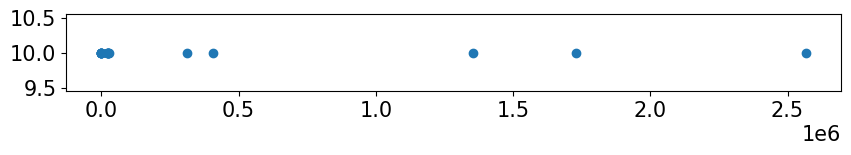

In [25]:
data = np.sort(new_res_df['num_keys'].unique())
print(data)
fig, ax = plt.subplots(figsize=(10, 1))
ax.scatter(data, [10] * len(data))

In [26]:
# decide the split points
def pairwise_difference(lst):
    differences = []
    prec_diffs = []
    for i in range(len(lst) - 1):
        prec_diffs.append((lst[i + 1] - lst[i])/lst[i])
        differences.append(lst[i + 1] - lst[i])
    return differences, prec_diffs
diffs, prec_diffs = pairwise_difference(data)
idxs = np.argsort(diffs)
prec_idxs = np.argsort(prec_diffs)

idx[12], between 312555 and 405302
idx[0], between 3 and 4
idx[15], between 1729761 and 2566911
idx[2], between 5 and 10
idx[4], between 50 and 100
idx[13], between 405302 and 1352857
idx[3], between 10 and 50
idx[11], between 28637 and 312555
idx[5], between 100 and 22478


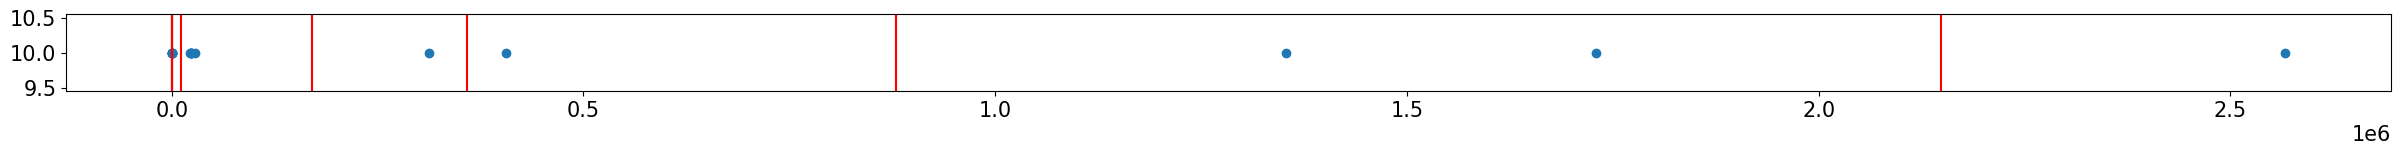

In [27]:
fig, ax = plt.subplots(figsize=(30, 1))
ax.scatter(data, [10] * len(data))
bins = [np.min(data)-1]
for idx in prec_idxs[-9:]:
    print(f'idx[{idx}], between {data[idx]} and {data[idx+1]}')
    curr_x = (data[idx] + data[idx + 1])/2
    bins.append(curr_x)
    ax.axvline(x=curr_x, color='red')
bins = np.sort(bins)
bins = np.append(bins, int(np.max(data)*1.01))

In [28]:
print(bins)

[2.000000e+00 3.500000e+00 7.500000e+00 3.000000e+01 7.500000e+01
 1.128900e+04 1.705960e+05 3.589285e+05 8.790795e+05 2.148336e+06
 2.592580e+06]


In [39]:
name_map = {
    'BEST' : '\\best ',
    'FREE' : '\\free ',
    'FAST' : '\\lpms ',
    'LPMS' : '\\lpms ',
    'Trig' : '\\trigram ',
    'VGGr': '\\vgg '
}

def check_min_cell(row, col, format_out, curr_group):
    curr_str = ''
    if row[col] == curr_group[col].min():
        curr_str += '& \cellcolor{green!50}{'
        curr_str += format_out
        curr_str += '} '
    else:
        curr_str += f'& {format_out} '
    return curr_str

def check_max_cell(row, col, format_out, curr_group):
    curr_str = ''
    if row[col] == curr_group[col].max():
        curr_str += '& \cellcolor{yellow!50}{'
        curr_str += format_out
        curr_str += '} '
    else:
        curr_str += f'& {format_out} '
    return curr_str
summary_df = None

lims = [5, 170000, 360000]#, 1500000]
for up_lim in lims:
# for up_lim in bins[2:]:
    curr_df = new_res_df[new_res_df['num_keys'] <= up_lim]
    # curr_group = curr_df.sort_values(by=['precision', 'overall_time'], ascending=[False, True]).groupby(['method']).first()
    curr_group = curr_df.sort_values(by=['precision', 'index_size'], ascending=[False, True]).groupby(['method']).first()
    # curr_group = curr_df.loc[curr_df.groupby(['method']).precision.idxmax()].sort_values(by='precision', ascending=False)
    # print(curr_group)
    # print(up_lim)
    curr_group['key_upper_bound'] = [up_lim]*curr_group.shape[0]
    curr_group = curr_group.sort_values(by='name')
    count = 0
    curr_row_count = curr_group.shape[0]
    curr_group['max_key'] = [up_lim]*curr_row_count    
    for _, row in curr_group.iterrows():
        curr_str = ''
        count += 1;
        if count == 1:
            curr_str += '\multirow{'+str(curr_row_count)+'}{*}{\\bf{'+ f'{up_lim:.1e}' + '}}'
        curr_str += f'& {name_map[row["name"][:4]]} '

        curr_str += check_min_cell(row, 'overall_match_time', f'{row["overall_match_time"]:.0f}', curr_group)
        curr_str += check_min_cell(row, 'overall_index_time', f'{row["overall_index_time"]:.0f}', curr_group)
        curr_str += check_min_cell(row, 'compute_size', f'{row["compute_size"]/1000000:.0f}', curr_group)
        curr_str += check_min_cell(row, 'index_size', f'{row["index_size"]/1000000:.1f}', curr_group)
        curr_str += check_max_cell(row, 'precision', f'{row["precision"]:.3f}', curr_group)
        print(curr_str, end='')
        if count < curr_row_count:
            print("\\\\ ")
        else:
            print("\\\\ \midrule")
            
    app = []
    for m in ALL_METHODS:
        if m not in curr_group.index:
            app.append({'name': m, 
                        'overall_index_time': 0,
                        'index_size': 0,
                        'compute_size': 0,
                        'precision': 0})
    for a in app:
        curr_group = curr_group.append(a, ignore_index=True)

    if summary_df is None:
        summary_df = curr_group
    else:
        summary_df = pd.concat([summary_df, curr_group], ignore_index=True)
summary_df['name'] = [ nm.split('-')[0] for nm in summary_df['name'].to_list()]

\multirow{3}{*}{\bf{5.0e+00}}& \best  & \cellcolor{green!50}{422} & 8587 & 150 & 0.1 & \cellcolor{yellow!50}{0.138} \\ 
& \free  & 440 & 382 & \cellcolor{green!50}{101} & \cellcolor{green!50}{0.1} & 0.123 \\ 
& \trigram  & 438 & \cellcolor{green!50}{99} & 101 & 501.2 & 0.124 \\ \midrule
\multirow{3}{*}{\bf{1.7e+05}}& \best  & 422 & 8587 & 150 & \cellcolor{green!50}{0.1} & 0.138 \\ 
& \free  & \cellcolor{green!50}{353} & 1184 & 159 & 357.9 & \cellcolor{yellow!50}{0.163} \\ 
& \trigram  & 436 & \cellcolor{green!50}{116} & \cellcolor{green!50}{101} & 152.1 & 0.124 \\ \midrule
\multirow{3}{*}{\bf{3.6e+05}}& \best  & 422 & 8587 & 150 & \cellcolor{green!50}{0.1} & 0.138 \\ 
& \free  & \cellcolor{green!50}{240} & 5965 & 240 & 2007.4 & \cellcolor{yellow!50}{0.301} \\ 
& \trigram  & 436 & \cellcolor{green!50}{116} & \cellcolor{green!50}{101} & 152.1 & 0.124 \\ \midrule


In [40]:
summary_df

,name,num_threads,gram_size,selectivity,num_keys,key_upper_bound,num_queries,selection_time,build_time,overall_index_time,...,match_time,overall_match_time,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size,prop_error,precision,max_key
0,BEST,16.0,-1.0,0.10,3.0,5.0,NaN,8586.840000,0.00008,8586.8400,...,421.630400,421.632543,9008.472543,6273158.0,627315.8,865241.0,150192364,0.862073,0.137927,5.0
1,FREE,16.0,2.0,0.02,5.0,5.0,0.0,173.312000,208.40300,381.7160,...,439.610620,439.612005,821.328005,6966370.0,696637.0,854718.0,100658272,0.877308,0.122692,5.0
2,Trigram,16.0,3.0,-1.00,5.0,5.0,10.0,0.029765,98.51100,98.5408,...,438.305521,438.330656,536.871456,6966370.0,696637.0,865241.0,101319108,0.875797,0.124203,5.0
3,LPMS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.000000,NaN
4,BEST,16.0,-1.0,0.10,3.0,170000.0,NaN,8586.840000,0.00008,8586.8400,...,421.630400,421.632543,9008.472543,6273158.0,627315.8,865241.0,150192364,0.862073,0.137927,170000.0
5,FREE,16.0,2.0,0.50,23076.0,170000.0,0.0,172.459000,1011.58000,1184.0400,...,352.959552,352.962331,1537.002331,5237063.0,523706.3,854718.0,159074964,0.836794,0.163206,170000.0
6,Trigram,16.0,3.0,-1.00,10.0,170000.0,10.0,0.022898,116.11100,116.1340,...,435.669517,435.670813,551.804813,6966370.0,696637.0,865241.0,101002268,0.875797,0.124203,170000.0
7,LPMS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.000000,NaN
8,BEST,16.0,-1.0,0.10,3.0,360000.0,NaN,8586.840000,0.00008,8586.8400,...,421.630400,421.632543,9008.472543,6273158.0,627315.8,865241.0,150192364,0.862073,0.137927,360000.0
9,FREE,16.0,4.0,0.70,312555.0,360000.0,0.0,1041.270000,4923.43000,5964.6900,...,239.813254,239.843169,6204.533169,2842640.0,284264.0,854392.0,240414828,0.699437,0.300563,360000.0


In [41]:
overall_df = None
for up_lim in lims: # bins[1:]:
    curr_df = new_res_df[new_res_df['num_keys'] <= up_lim]
    print(up_lim)
    # print(curr_df.groupby(['method']).precision.idxmax())
    # curr_group = curr_df.loc[curr_df.groupby(['method']).precision.idxmax()].sort_values(by='precision', ascending=False)
    curr_group = curr_df.sort_values(by=['precision', 'overall_time'], ascending=[False, True]).groupby(['method']).first()
    curr_group['key_upper_bound'] = [up_lim]*curr_group.shape[0]
    app = []
    for m in ALL_METHODS:
        if m not in curr_group.index:
            app.append({'name': m, 
                        'num_keys': up_lim-1,
                        'overall_index_time': 0,
                        'index_size': 0,
                        'compute_size': 0,
                        'precision': 0})
    for a in app:
        curr_group = curr_group.append(a, ignore_index=True)
    if overall_df is None:
        overall_df = curr_group
    else:
        overall_df = overall_df.append(curr_group, ignore_index=True)
overall_df['name'] = [ nm.split('-')[0] for nm in overall_df['name'].to_list()]

5
170000
360000


In [42]:
overall_df

,name,num_threads,gram_size,selectivity,num_keys,key_upper_bound,num_queries,selection_time,build_time,overall_index_time,...,compile_time,match_time,overall_match_time,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size,prop_error,precision
0,BEST,16.0,-1.0,0.10,3,5.0,NaN,8586.840000,0.00008,8586.8400,...,0.002143,421.630400,421.632543,9008.472543,6273158.0,627315.8,865241.0,150192364,0.862073,0.137927
1,FREE,16.0,2.0,0.02,5,5.0,0.0,173.312000,208.40300,381.7160,...,0.001385,439.610620,439.612005,821.328005,6966370.0,696637.0,854718.0,100658272,0.877308,0.122692
2,Trigram,16.0,3.0,-1.00,5,5.0,10.0,0.029765,98.51100,98.5408,...,0.025135,438.305521,438.330656,536.871456,6966370.0,696637.0,865241.0,101319108,0.875797,0.124203
3,LPMS,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.000000
4,BEST,16.0,-1.0,0.10,3,170000.0,NaN,8586.840000,0.00008,8586.8400,...,0.002143,421.630400,421.632543,9008.472543,6273158.0,627315.8,865241.0,150192364,0.862073,0.137927
5,FREE,16.0,2.0,0.50,23076,170000.0,0.0,172.459000,1011.58000,1184.0400,...,0.002779,352.959552,352.962331,1537.002331,5237063.0,523706.3,854718.0,159074964,0.836794,0.163206
6,Trigram,16.0,3.0,-1.00,5,170000.0,10.0,0.029765,98.51100,98.5408,...,0.025135,438.305521,438.330656,536.871456,6966370.0,696637.0,865241.0,101319108,0.875797,0.124203
7,LPMS,NaN,NaN,NaN,169999,NaN,NaN,NaN,NaN,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.000000
8,BEST,16.0,-1.0,0.10,3,360000.0,NaN,8586.840000,0.00008,8586.8400,...,0.002143,421.630400,421.632543,9008.472543,6273158.0,627315.8,865241.0,150192364,0.862073,0.137927
9,FREE,16.0,4.0,0.70,312555,360000.0,0.0,1041.270000,4923.43000,5964.6900,...,0.029915,239.813254,239.843169,6204.533169,2842640.0,284264.0,854392.0,240414828,0.699437,0.300563


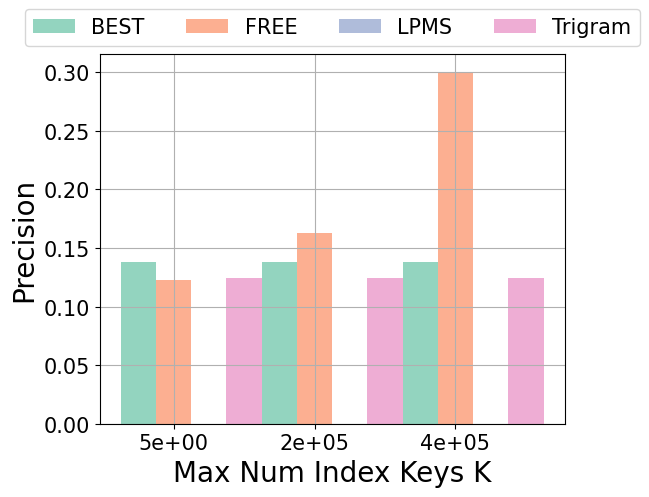

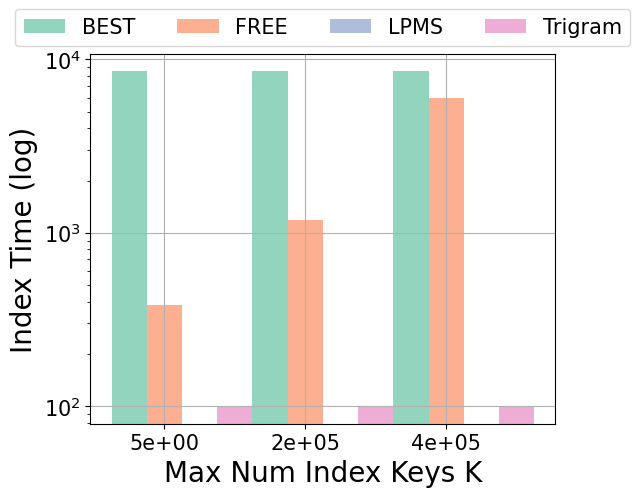

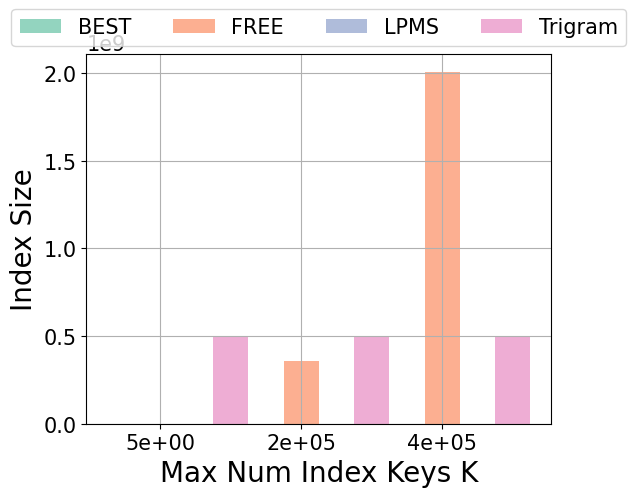

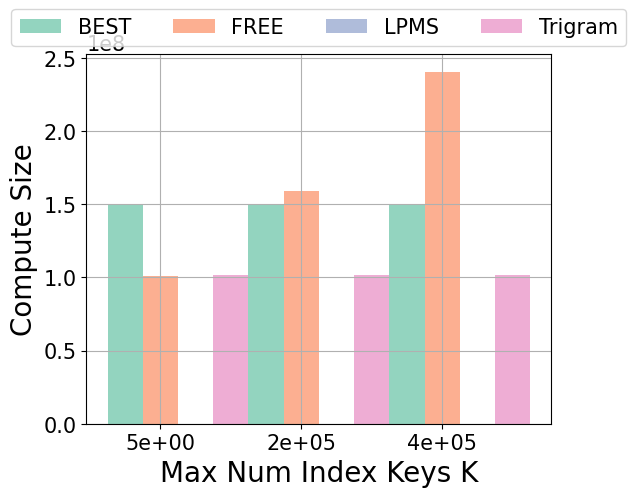

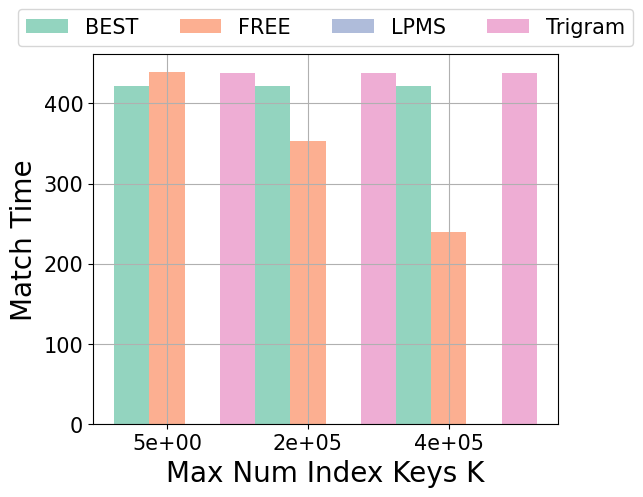

In [43]:
from matplotlib.ticker import ScalarFormatter

colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']
for col in ['precision', 'overall_index_time', 'index_size', 'compute_size', 'overall_match_time']:
    # fig, ax = plt.subplots(figsize=(4,2.8))
    # fig, ax = plt.subplots(figsize=(6,4.2))
    fig, ax = plt.subplots(figsize=(6,4.8))
        
    x = np.arange(len(lims))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0
    for method, color in zip(ALL_METHODS, colors):
        curr = overall_df.loc[overall_df["name"] == method]#.sort_values('name')
        
        X = curr['key_upper_bound']
        
        # fig, ax = plt.subplots(layout='constrained')
        offset = width * multiplier - width
        Y = curr[col].to_numpy()
        rects = ax.bar(x + offset, Y, width, alpha=0.7, label=method, color=color)
        multiplier += 1
        
    ylb = ' '.join([w.capitalize() for w in col.split('_')[-2:]])
    if col == 'overall_index_time':
        ax.set_yscale('log')
        ax.ticklabel_format(axis='x', scilimits=[-3,3])
        ylb += ' (log)'
    else:
        ax.ticklabel_format(scilimits=[-3,3])
    ax.set_ylabel(ylb)
    ax.set_xlabel('Max Num Index Keys K')

    ax.set_xticks(ticks=x, labels=[f'{int(v):.0e}' for v in lims])

    plt.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.15))
    plt.grid()
    plt.savefig(f'figs/{FIG_PREFIX}_{col}.pdf', bbox_inches='tight')
    plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(data, bins=bins, edgecolor='black', alpha=0.5)
print(np.log(bins))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.gca().set_xscale("log")
ax.set_xticks(bins)
ax.set_xticklabels([int(b) for b in bins], rotation=45)

ax2 = ax.twinx()

for (name, new_group), color in zip(new_groups, colors):
    new_group.loc[new_group["selectivity"] == -1, "selectivity"] = 1

    X = new_group['num_keys']
    Y = new_group['precision']
    ax2.plot(X, Y, c=color)
    curr_lab = new_group['name'].to_list()[0].split('-')[0]
    if name[1] != -1:
        curr_lab += f' n={name[1]}'
    sc = ax2.scatter(X, Y, marker='o', label=curr_lab, c=color,
               edgecolors='black', #alpha=new_group['selectivity'].to_list(), 
               s=1000*new_group['selectivity'].to_numpy())
    if name[0] == 'FREE-parallel':
        labs = (new_group['selectivity'].unique())
        labs = np.sort(labs)
        handles, labels = sc.legend_elements(prop="sizes", alpha=0.4,num=4)     
        # labels = new_group['selectivity'].unique()    
        # legend = ax.legend(handles, [" " , "Selectivity\nThreshold"," " ,  " "], title="Size")
        # ax.legend(*sc.legend_elements("sizes", num=4, alpha=0.5), loc='center right')

    # for g, s, x, y in zip(new_group['gram_size'], new_group['selectivity'], X, Y):
    #     ax2.annotate('(%s, %s)' % (g, s), xy=(x,y), textcoords='data') # <--
ax2.set_ylabel('Precision')
ax.set_ylabel('Index Count')
ax.set_xlabel('num_keys')
plt.legend(labelspacing=2)
# plt.savefig(f'figs/{FIG_PREFIX}_numkey_prec_hist.pdf', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(data, bins=bins, edgecolor='black');
# plt.gca().set_xscale("log")
ax2 = ax.twinx()

for (name, new_group), color in zip(new_groups, colors):
    new_group.loc[new_group["selectivity"] == -1, "selectivity"] = 1
    if name == 'FREE-parallel':
        curr_new_group = new_group[new_group['gram_size'] == 4]
    else:
        curr_new_group = new_group
    X = curr_new_group['num_keys']
    Y = curr_new_group['precision']
    ax2.plot(X, Y, c=color)
    ax2.scatter(X, Y, marker='o', label=curr_new_group['name'].to_list()[0], c=color,
               edgecolors='black', #alpha=new_group['selectivity'].to_list(), 
               s=1000*curr_new_group['selectivity'].to_numpy())
    for g, s, x, y in zip(curr_new_group['gram_size'], curr_new_group['selectivity'], X, Y):
        ax2.annotate('(%s, %s)' % (g, s), xy=(x,y), textcoords='data') # <--
ax2.set_ylabel('precision')
ax.set_ylabel('count')
ax.set_xlabel('num_keys')
ax.set_xlim([0, 6000])
plt.legend(labelspacing=2)

In [ ]:
# bin them by number of 
BIN_NUM = 10
new_res_df.hist(column='num_keys', bins=BIN_NUM)
heights, bins = np.histogram(data, bins=BIN_NUM)

In [ ]:
_, bins = np.histogram(np.log10(data + 1), bins=BIN_NUM)
plt.hist(data, bins=10**bins);
plt.gca().set_xscale("log")

In [ ]:
edges = 10**bins
prev = 0
for b in edges:
    print(new_res_df[(new_res_df['num_keys'] < b) & (new_res_df['num_keys'] >= prev)].sort_values(by='num_after_filter', ascending=True)[['name', 'num_keys', 'selection_time', 'num_after_filter']])
    prev = b
print([int(e) for e in edges])

In [ ]:
sns.histplot(new_res_df['num_keys'], bins=BIN_NUM, log_scale=True)

In [ ]:
prev = 0
for b in bins:
    print(new_res_df[(new_res_df['num_keys'] < b) & (new_res_df['num_keys'] >= prev)].sort_values(by='num_after_filter', ascending=True))
    prev = b

In [ ]:
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))
x = new_res_df['num_keys'].to_numpy()
n, bins, patches = plt.hist(x, histedges_equalN(x, 20))

In [ ]:
prev = 0
for b in bins:
    print(new_res_df[(new_res_df['num_keys'] < b) & (new_res_df['num_keys'] >= prev)].sort_values(by='num_after_filter', ascending=True))
    prev = b

In [ ]:
best_df = res_df[res_df['name'].str.contains('BEST')]

In [ ]:
free_df = res_df[(res_df['name'] == 'FREE') | (res_df['name'] == 'FREE-parallel')]

In [ ]:
# free with c = 0.1, plot false positive rate against gramsize 
# free_df = res_df[(res_df['name'] == 'FREE') | (res_df['name'] == 'FREE-parallel')]
temp_free = free_df[free_df['selectivity'] == 0.1]

In [ ]:
# gram size vs accuracy
temp = temp_free[temp_free['num_threads'] == 1]
ax = plt.subplot()
x = temp['gram_size']
y = (temp['num_after_filter'] - temp['match_count']) / temp['num_after_filter']
ax.plot(x, y) 
plt.xlabel('Max Gram Size')
plt.ylabel('False Positive Rate')
plt.show()

In [ ]:
# gram size vs index size; gram size vs index build time
fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios': [2, 1]}, sharex=True)

colors = ['#66c2a5','#fc8d62','#8da0cb']

temp = temp_free[temp_free['num_threads'] == 1]
x = temp['gram_size']
y_1 = temp['overall_index_time']
y_1_1 = temp['selection_time']
y_1_2 = temp['build_time']

y_2 = temp['num_keys']

axs[0].stackplot(x, y_1_1, y_1_2, labels=[
    'Gram Selection', 'Posting Lists Filling' #, 'Overall Index Construction'
],
    colors=colors[:-1])

# axs[0].plot(x, y_1, label='Overall Index Construction') 
# axs[0].plot(x, y_1_1, label='Gram Selection') 
# axs[0].plot(x, y_1_2, label='Posting Lists Filling') 
axs[0].set_ylabel('Time (s)')
axs[0].legend(loc='upper left')

axs[1].plot(x, y_2, marker='o', c=colors[-1])
axs[1].set_ylabel('Num Selected')

plt.xlabel('Max Gram Size')
plt.savefig(f'figs/{FIG_PREFIX}free_n_vs_index-time_num-keys.pdf', bbox_inches='tight')

plt.show()

In [ ]:
# thread vs. build time; label by gram size
ax = plt.subplot()
seq_colors = sns.color_palette("flare")#, as_cmap=True)
for i, gram_size in enumerate(temp_free['gram_size'].unique()):
    temp = temp_free[temp_free['gram_size'] == gram_size]
    x = temp['num_threads']
    y = temp['overall_index_time']
    ax.plot(x, y, label='FREE max {}-grams'.format(int(gram_size)), marker='o', color=seq_colors[i]) 
# ax.set_facecolor('gainsboro')
plt.xlabel('Number of Threads')
plt.ylabel('Index Building Time (s)')
plt.legend() 
plt.savefig(f'figs/{FIG_PREFIX}free_thread_vs_index-time.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# thread vs. build time; label by gram size
# temp_best = best_df[best_df['selectivity'] == 0.05]
# print(temp_best)
ax = plt.subplot()
seq_colors = sns.color_palette("crest")#, n_colors=11)#, as_cmap=True)
# for i, sel in enumerate(best_df['selectivity'].unique()):
for i, sel in enumerate([0.01, 0.05,0.1, 0.2]):
    temp = best_df[best_df['selectivity'] == sel]
    x = temp['num_threads']
    y = temp['overall_index_time']
    ax.plot(x, y, label='BEST c <= {}'.format(sel), marker='o', color=seq_colors[i]) 
# ax.set_facecolor('gainsboro')
plt.xlabel('Number of Threads')
plt.ylabel('Index Building Time (s)')
plt.legend() 
plt.savefig(f'figs/{FIG_PREFIX}_best_thread_vs_index-time.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# res_df = add_num_after_filter(res_df)
# res_df.describe()

In [ ]:
# res_df.columns

In [ ]:
# res_df

In [ ]:
    # curr_group = curr_df.loc[curr_df.groupby(['method']).precision.idxmax()].sort_values(by='precision', ascending=False)
